# **Enhanced Ship Detection in Satellite Images using Hybrid Deep Learning and Machine Learning Approaches**

## - Smit Patel, Tirth Halvadia, Nidhi Patel

In [1]:
!pip install keras
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from numpy import expand_dims
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras import callbacks
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

2024-05-08 22:08:57.330491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 22:08:57.330613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 22:08:57.625976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
with open('/kaggle/input/ships-in-satellite-imagery/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head(1000)

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007
...,...,...,...,...
995,"[103, 95, 99, 108, 110, 125, 131, 125, 133, 13...",1,"[-122.34862085843947, 37.767167357603554]",20170921_181406_1031
996,"[75, 75, 75, 75, 74, 70, 69, 72, 73, 72, 70, 6...",1,"[-122.33786604607423, 37.73944613318674]",20170604_180820_0f52
997,"[75, 74, 75, 75, 74, 74, 75, 76, 76, 75, 75, 7...",1,"[-122.33284969739871, 37.71792145705744]",20170721_180825_100b
998,"[49, 50, 49, 45, 49, 53, 52, 46, 43, 44, 49, 5...",1,"[-122.35668820008198, 37.75991104734941]",20170618_180801_0f34


In [4]:
print(len(shipsnet['data'][0]))

19200


In [5]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [6]:
shipsnet = shipsnet[["data","labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [7]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the ship_images :1000


In [8]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [9]:
x.shape

(4000, 19200)

In [10]:
x

array([[ 82,  89,  91, ...,  86,  88,  89],
       [ 76,  75,  67, ...,  54,  57,  58],
       [125, 127, 129, ..., 111, 109, 115],
       ...,
       [171, 135, 118, ...,  95,  95,  85],
       [ 85,  90,  94, ...,  96,  95,  89],
       [122, 122, 126, ...,  51,  46,  69]], dtype=uint8)

In [11]:
x_reshaped = x.reshape([-1, 3, 80, 80])

In [12]:
x_reshaped

array([[[[ 82,  89,  91, ...,  89,  84,  83],
         [ 89,  91,  89, ..., 101,  87,  87],
         [ 91,  93,  86, ...,  83,  90,  92],
         ...,
         [ 89,  88,  92, ...,  88,  85,  89],
         [ 87,  88,  91, ...,  91,  90,  90],
         [ 88,  91,  90, ...,  88,  89,  90]],

        [[ 94,  99, 101, ..., 102,  96,  96],
         [100, 102, 101, ..., 115, 100,  99],
         [101, 104,  98, ...,  96, 102, 102],
         ...,
         [ 98,  98, 102, ...,  99,  97, 100],
         [ 99,  99, 101, ..., 101, 101, 102],
         [ 99, 101, 101, ..., 101, 102, 102]],

        [[ 80,  86,  89, ...,  86,  81,  84],
         [ 86,  88,  89, ...,  97,  84,  86],
         [ 88,  92,  85, ...,  81,  88,  89],
         ...,
         [ 87,  86,  89, ...,  86,  84,  87],
         [ 87,  86,  88, ...,  88,  88,  89],
         [ 85,  87,  87, ...,  86,  88,  89]]],


       [[[ 76,  75,  67, ...,  78,  77,  80],
         [ 71,  73,  72, ...,  79,  77,  81],
         [ 73,  70,  67, ..., 

In [13]:
x_reshaped[0].shape

(3, 80, 80)

In [14]:
print(x_reshaped[0][0])

[[ 82  89  91 ...  89  84  83]
 [ 89  91  89 ... 101  87  87]
 [ 91  93  86 ...  83  90  92]
 ...
 [ 89  88  92 ...  88  85  89]
 [ 87  88  91 ...  91  90  90]
 [ 88  91  90 ...  88  89  90]]


In [15]:
x_reshaped[0][0].shape

(80, 80)

In [16]:
print(x_reshaped[0][1])

[[ 94  99 101 ... 102  96  96]
 [100 102 101 ... 115 100  99]
 [101 104  98 ...  96 102 102]
 ...
 [ 98  98 102 ...  99  97 100]
 [ 99  99 101 ... 101 101 102]
 [ 99 101 101 ... 101 102 102]]


In [17]:
print(x_reshaped[0])

[[[ 82  89  91 ...  89  84  83]
  [ 89  91  89 ... 101  87  87]
  [ 91  93  86 ...  83  90  92]
  ...
  [ 89  88  92 ...  88  85  89]
  [ 87  88  91 ...  91  90  90]
  [ 88  91  90 ...  88  89  90]]

 [[ 94  99 101 ... 102  96  96]
  [100 102 101 ... 115 100  99]
  [101 104  98 ...  96 102 102]
  ...
  [ 98  98 102 ...  99  97 100]
  [ 99  99 101 ... 101 101 102]
  [ 99 101 101 ... 101 102 102]]

 [[ 80  86  89 ...  86  81  84]
  [ 86  88  89 ...  97  84  86]
  [ 88  92  85 ...  81  88  89]
  ...
  [ 87  86  89 ...  86  84  87]
  [ 87  86  88 ...  88  88  89]
  [ 85  87  87 ...  86  88  89]]]


In [18]:
x_reshaped[0][0].shape

(80, 80)

In [19]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [20]:
print(x_reshaped[0][79])

[[ 88  99  85]
 [ 91 101  87]
 [ 90 101  87]
 [ 88 100  87]
 [ 89  99  88]
 [ 89  99  88]
 [ 86  96  84]
 [ 92 101  89]
 [ 90 100  87]
 [ 87  97  84]
 [ 86  98  84]
 [ 90 102  87]
 [ 89 100  85]
 [ 90 100  86]
 [ 89 100  86]
 [ 87  99  86]
 [ 86  99  85]
 [ 90 102  88]
 [ 90 100  86]
 [ 92 102  89]
 [ 89 100  87]
 [ 89 100  87]
 [ 89 100  88]
 [ 86  97  84]
 [ 84  95  82]
 [ 85  97  85]
 [ 90 100  90]
 [ 90 100  91]
 [ 87  98  88]
 [ 90 100  89]
 [ 86  97  86]
 [ 88  98  87]
 [ 90 101  89]
 [ 88 100  87]
 [ 85  98  85]
 [ 86 100  86]
 [ 86  99  86]
 [ 90 101  88]
 [ 91 101  89]
 [ 90  99  87]
 [ 89  97  86]
 [ 91 100  89]
 [ 90  99  88]
 [ 90 100  89]
 [ 89 100  88]
 [ 89  99  86]
 [ 92 101  87]
 [ 96 104  93]
 [ 91 100  88]
 [ 91 101  89]
 [ 89 101  87]
 [ 86  99  85]
 [ 88  99  87]
 [ 94 103  92]
 [ 93 101  90]
 [ 87  95  83]
 [ 85  95  82]
 [ 93 103  88]
 [ 99 108  93]
 [ 91 101  89]
 [ 90 101  91]
 [ 89 100  91]
 [ 89 100  90]
 [ 92 103  92]
 [ 92 103  94]
 [ 94 103  92]
 [ 91 100 

In [21]:
x_reshaped[0][4].shape

(80, 3)

In [22]:
y.shape

(4000,)

In [23]:
y_reshaped = to_categorical(y, num_classes=2)
y_reshaped.shape

(4000, 2)

In [24]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

### **Exploring the images**

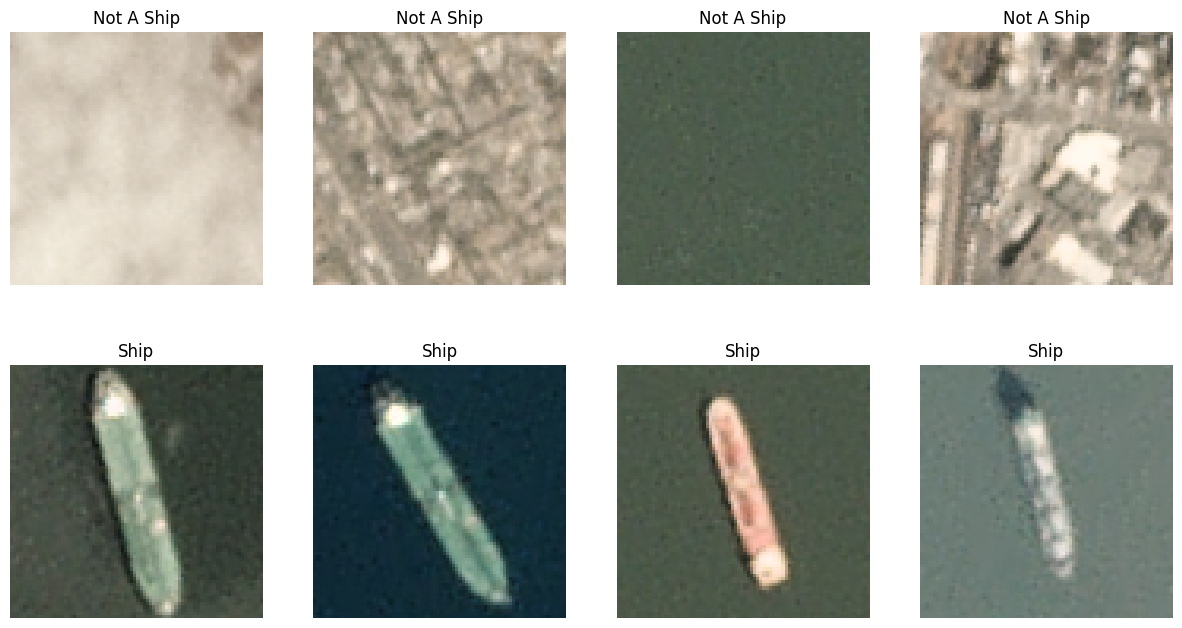

In [25]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

#Implementation of the function 

plot(image_no_ship, image_ship)

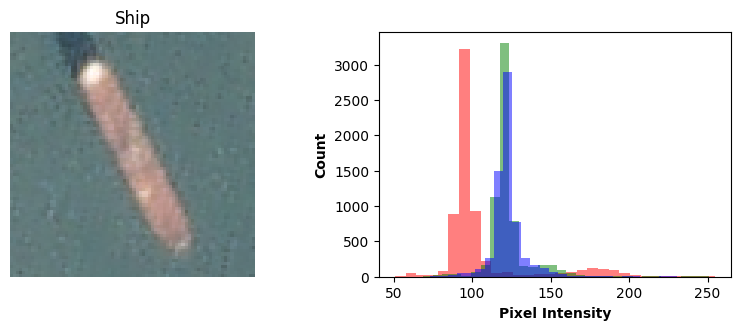

Minimum pixel value of this image: 51
Maximum pixel value of this image: 255


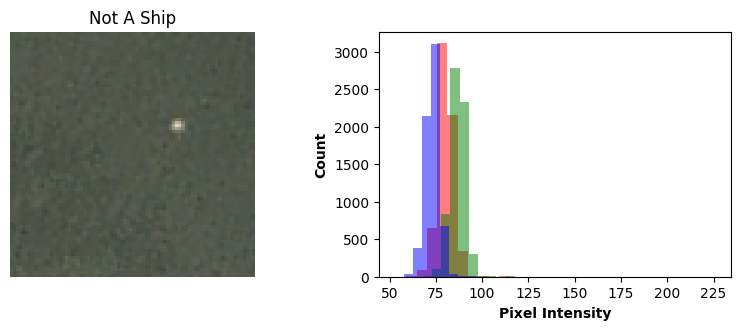

Minimum pixel value of this image: 53
Maximum pixel value of this image: 226


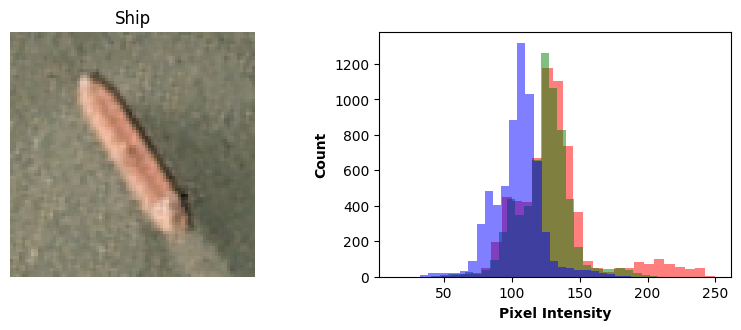

Minimum pixel value of this image: 14
Maximum pixel value of this image: 250


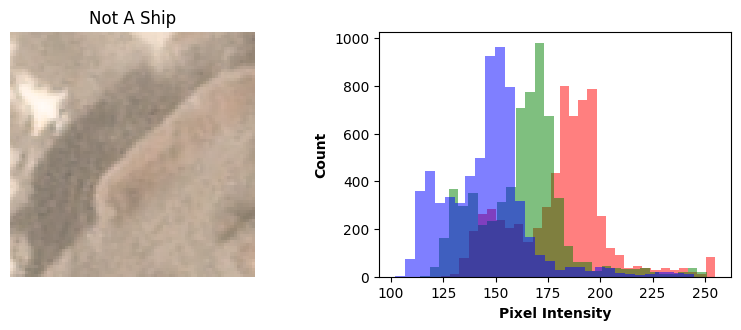

Minimum pixel value of this image: 102
Maximum pixel value of this image: 255


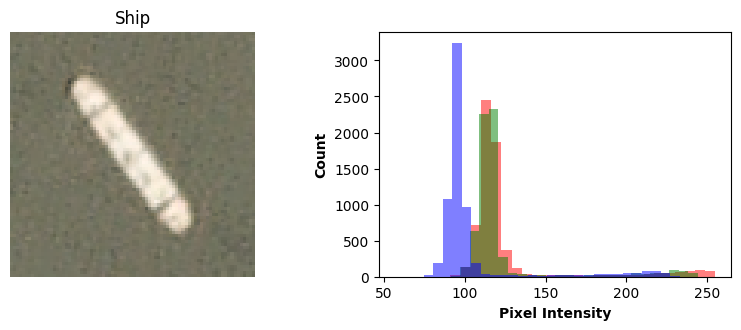

Minimum pixel value of this image: 57
Maximum pixel value of this image: 255


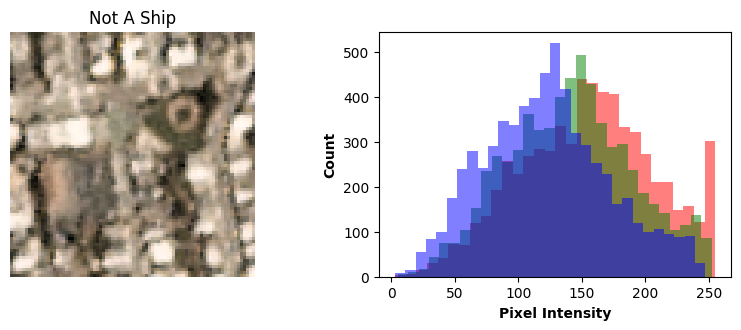

Minimum pixel value of this image: 3
Maximum pixel value of this image: 255


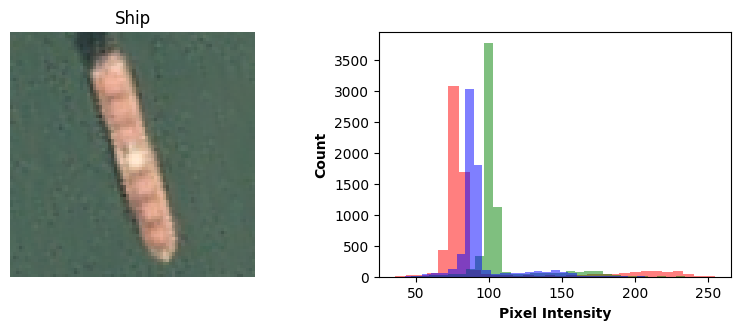

Minimum pixel value of this image: 36
Maximum pixel value of this image: 255


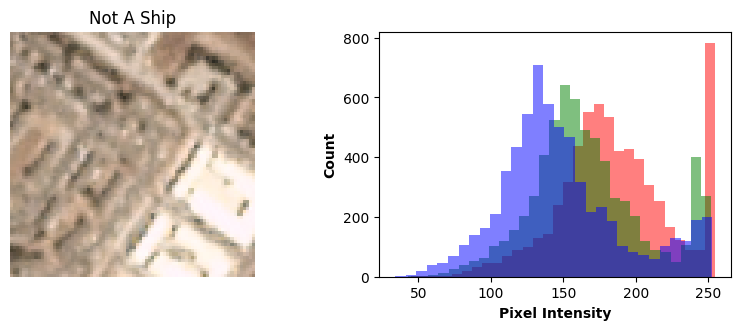

Minimum pixel value of this image: 34
Maximum pixel value of this image: 255


In [26]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))
#Implementation of the function

for i in range (10,14):
    plotHistogram(x_reshaped[y==1][i], x_reshaped[y==0][i])

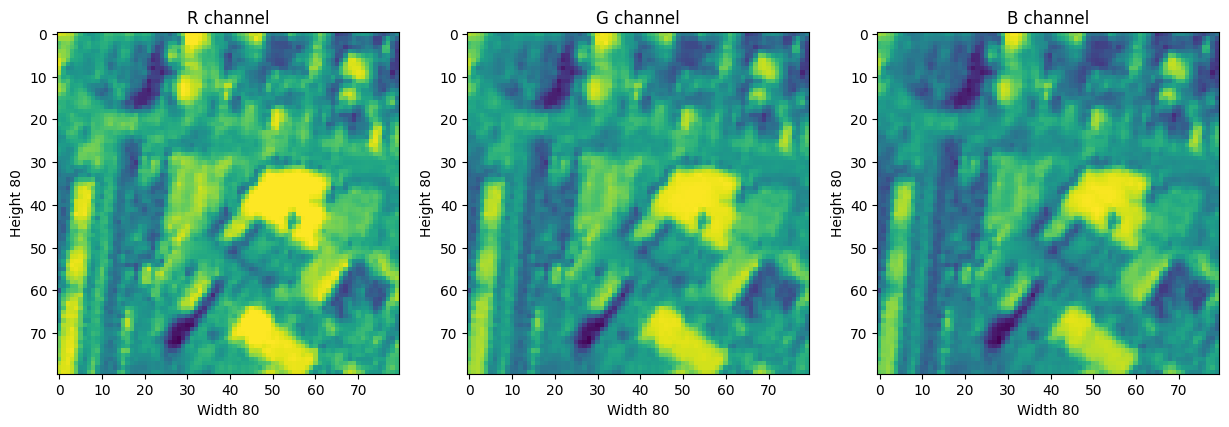

In [27]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

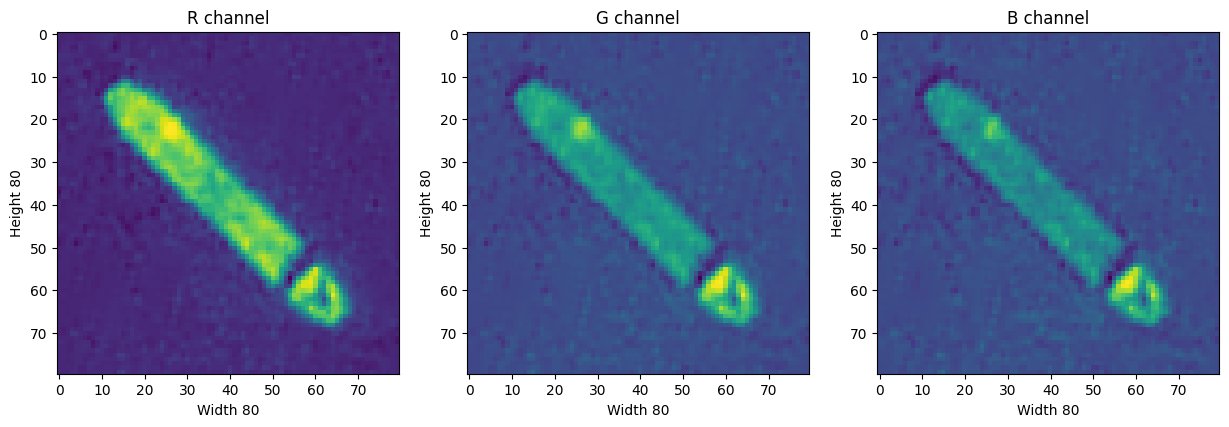

In [28]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

### **Modelling**

In [29]:
x_reshaped = x_reshaped / 255

In [30]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0.32156863, 0.36862745, 0.31372549])

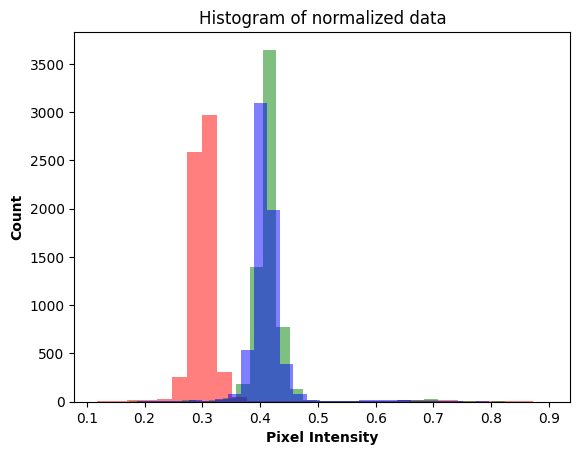

In [31]:
n_bins = 30
plt.hist(x_reshaped[y == 0][0][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
plt.ylabel('Count', fontweight = "bold")
plt.xlabel('Pixel Intensity', fontweight = "bold")
plt.title("Histogram of normalized data")
plt.show()

In [32]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)
print("x_train_1 shape",x_train_1.shape)
print("x_val shape",x_val.shape)
print("y_train_1 shape",y_train_1.shape)

x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 80, 80, 3)
y_test shape (800, 2)
x_train_1 shape (3200, 80, 80, 3)
x_val shape (800, 80, 80, 3)
y_train_1 shape (3200, 2)


In [33]:
x_test.shape

(800, 80, 80, 3)

In [34]:
x_train.shape

(2400, 80, 80, 3)

### **VGG-16 Pretrained on ImageNet**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
11/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

I0000 00:00:1715206194.744161      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
SVM Accuracy: 0.9925
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       591
           1       0.99      0.98      0.99       209

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



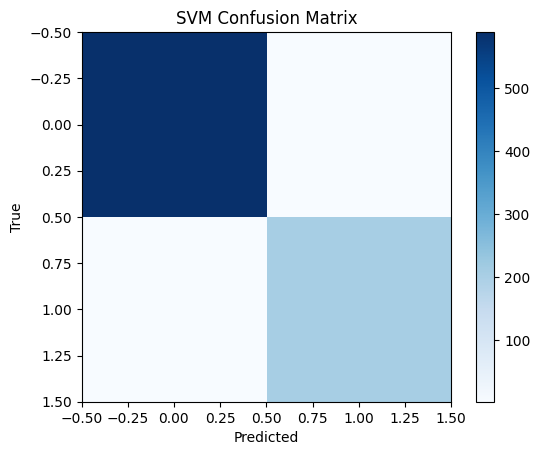

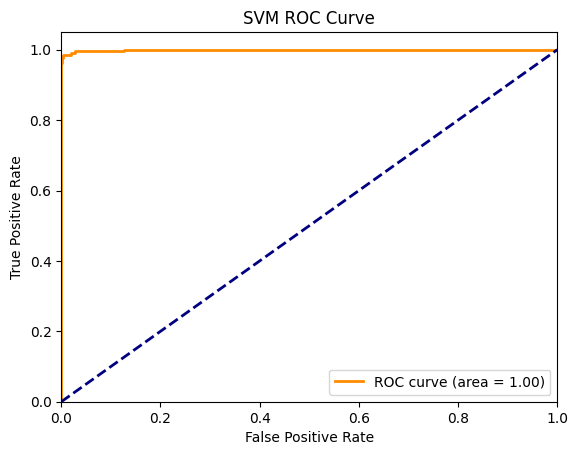

XGBoost Accuracy: 0.99375
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       591
           1       1.00      0.98      0.99       209

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



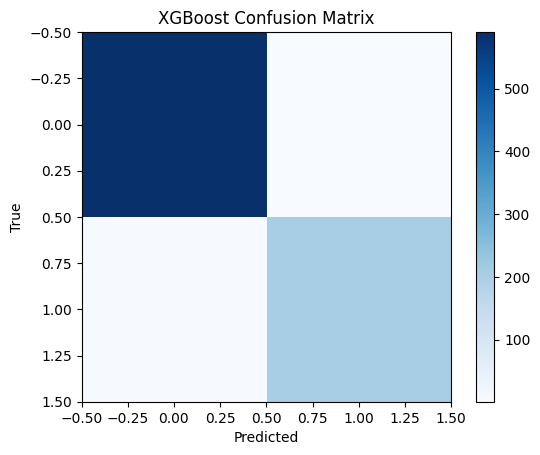

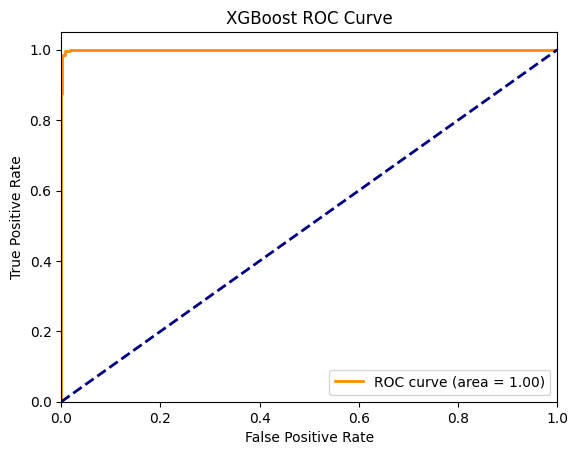

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.99125
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       591
           1       0.99      0.98      0.98       209

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



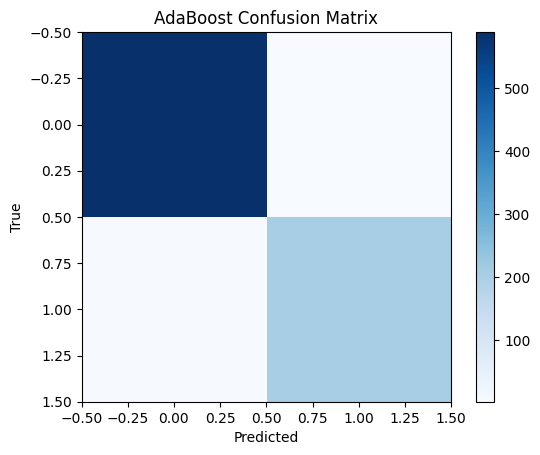

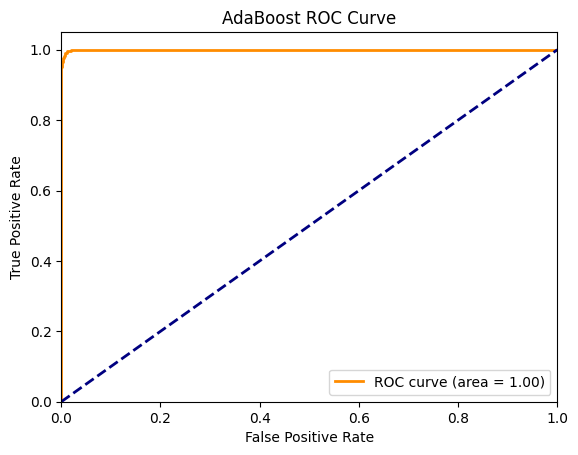

Random Forest Accuracy: 0.98
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       591
           1       0.98      0.94      0.96       209

    accuracy                           0.98       800
   macro avg       0.98      0.97      0.97       800
weighted avg       0.98      0.98      0.98       800



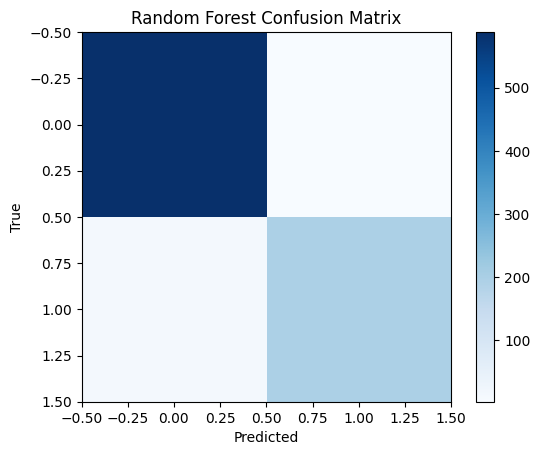

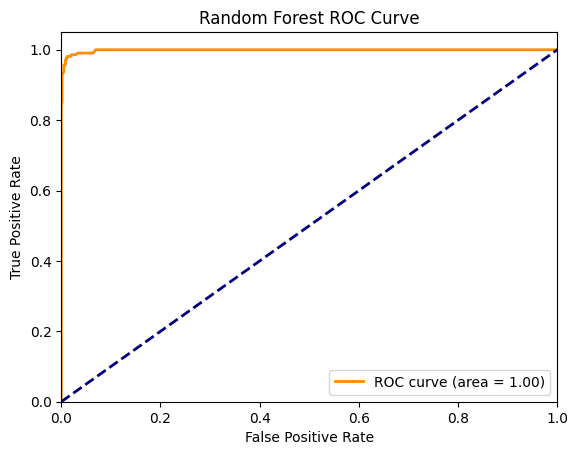

Stochastic Gradient Boosting Accuracy: 0.97375
Stochastic Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       591
           1       1.00      0.90      0.95       209

    accuracy                           0.97       800
   macro avg       0.98      0.95      0.96       800
weighted avg       0.97      0.97      0.97       800



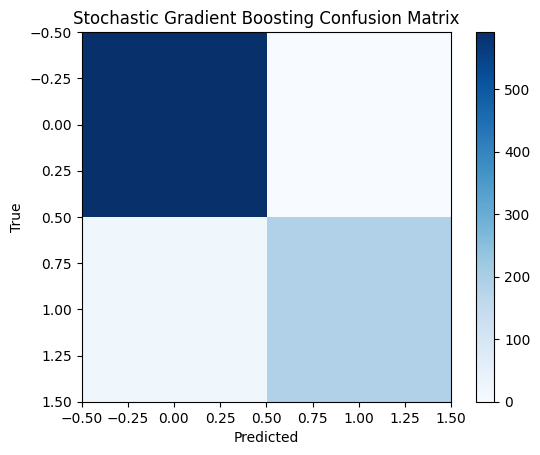

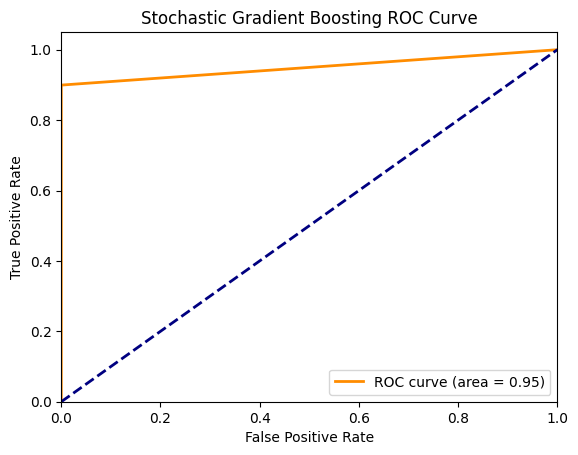

In [35]:
# Load pre-trained VGG16 model without classification layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze the convolutional base
for layer in vgg16_base.layers:
    layer.trainable = False

# Extract features using VGG16 base
x_train_features = vgg16_base.predict(x_train)
x_test_features = vgg16_base.predict(x_test)

# Flatten the features
x_train_features_flat = x_train_features.reshape(x_train_features.shape[0], -1)
x_test_features_flat = x_test_features.reshape(x_test_features.shape[0], -1)

# Define classifiers
classifiers = {
    "SVM": SVC(kernel='linear'),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Stochastic Gradient Boosting": SGDClassifier(loss='modified_huber', shuffle=True, random_state=101)
}

# Loop through classifiers
for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(x_train_features_flat, np.argmax(y_train, axis=1))
    
    # Evaluate the classifier
    y_pred = clf.predict(x_test_features_flat)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    print(f"{clf_name} Accuracy: {accuracy}")
    
    # Classification report
    clf_report = classification_report(np.argmax(y_test, axis=1), y_pred)
    print(f"{clf_name} Classification Report:\n{clf_report}")
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{clf_name} Confusion Matrix")
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC curve
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(x_test_features_flat)[:,1]
    else:
        y_score = clf.decision_function(x_test_features_flat)
    
    fpr, tpr, _ = roc_curve(np.argmax(y_test, axis=1), y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{clf_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### **ResNet-50**

In [36]:
# Load RESNET model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

# Freeze layers
for layer in resnet_model.layers:
    layer.trainable = False

# Add GlobalAveragePooling2D layer
x = resnet_model.output
x = GlobalAveragePooling2D()(x)

# Create model for feature extraction
feature_extraction_model = Model(inputs=resnet_model.input, outputs=x)

# Extract features from RESNET for training and testing data
x_train_features = feature_extraction_model.predict(x_train)
x_test_features = feature_extraction_model.predict(x_test)

# Reshape features if necessary
if len(x_train_features.shape) > 2:
    x_train_features = np.reshape(x_train_features, (x_train_features.shape[0], -1))
    x_test_features = np.reshape(x_test_features, (x_test_features.shape[0], -1))

# Convert one-hot encoded labels to 1D array
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


SVM Accuracy: 0.9375
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       591
           1       0.92      0.84      0.88       209

    accuracy                           0.94       800
   macro avg       0.93      0.91      0.92       800
weighted avg       0.94      0.94      0.94       800



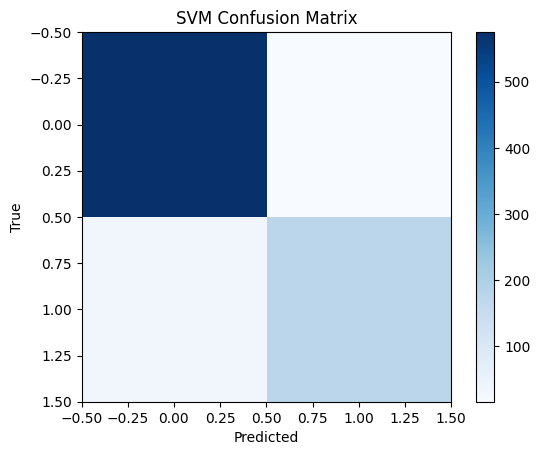

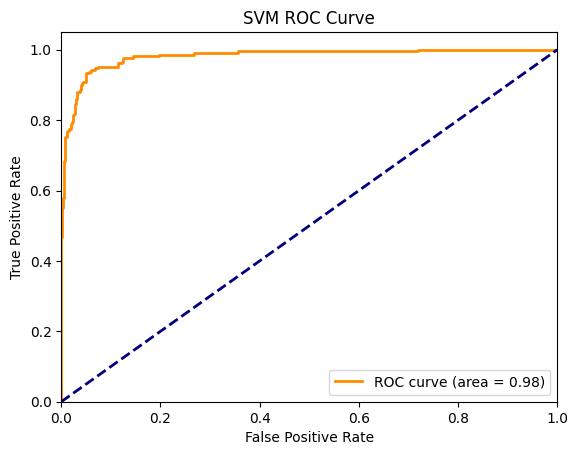

XGBoost Accuracy: 0.95625
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       591
           1       0.95      0.88      0.91       209

    accuracy                           0.96       800
   macro avg       0.95      0.93      0.94       800
weighted avg       0.96      0.96      0.96       800



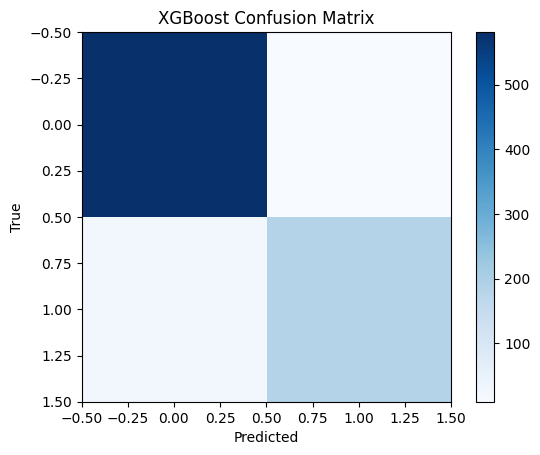

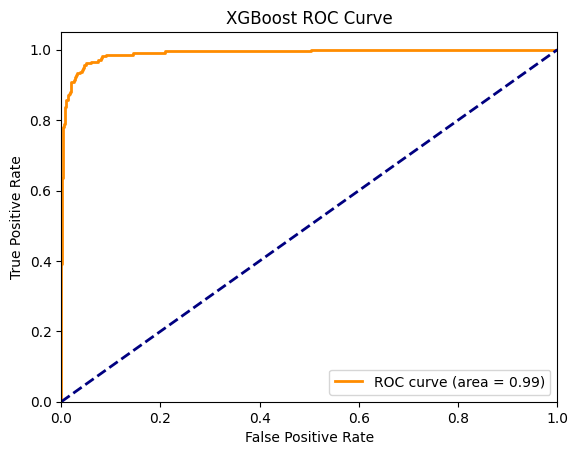

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.91625
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       591
           1       0.89      0.78      0.83       209

    accuracy                           0.92       800
   macro avg       0.91      0.87      0.89       800
weighted avg       0.92      0.92      0.91       800



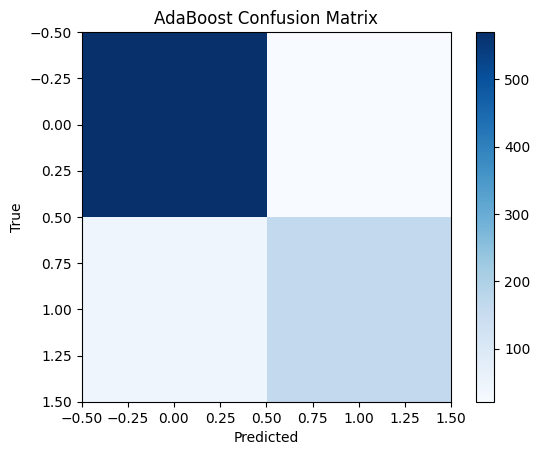

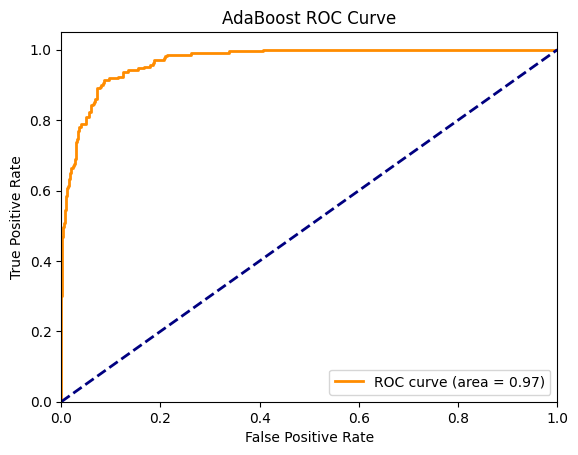

Random Forest Accuracy: 0.93
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       591
           1       0.94      0.78      0.85       209

    accuracy                           0.93       800
   macro avg       0.93      0.88      0.90       800
weighted avg       0.93      0.93      0.93       800



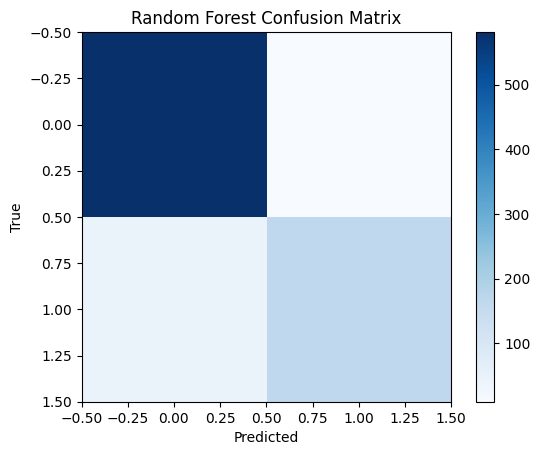

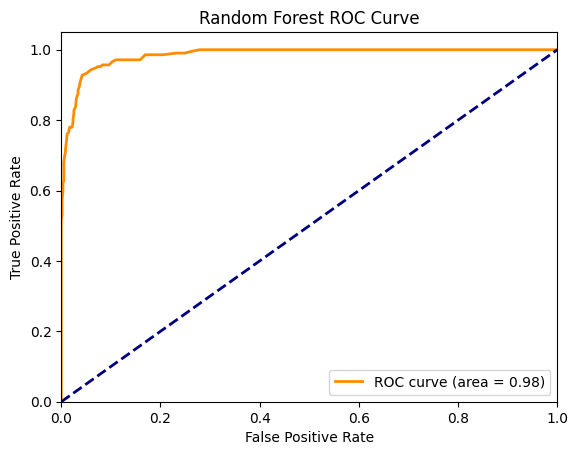

Stochastic Gradient Boosting Accuracy: 0.8975
Stochastic Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.93       591
           1       0.73      0.96      0.83       209

    accuracy                           0.90       800
   macro avg       0.86      0.92      0.88       800
weighted avg       0.92      0.90      0.90       800



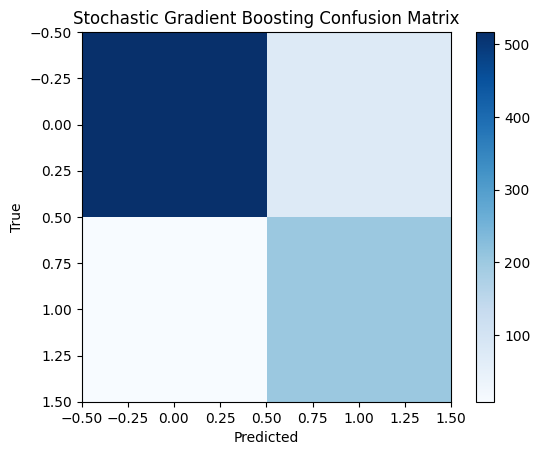

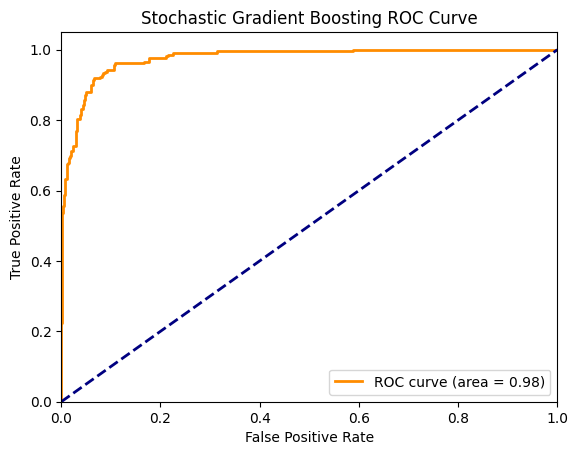

In [37]:
# Loop through classifiers
for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(x_train_features, y_train_1d)
    
    # Evaluate the classifier
    accuracy = clf.score(x_test_features, y_test_1d)
    print(f"{clf_name} Accuracy: {accuracy}")
    
    # Classification report
    y_pred = clf.predict(x_test_features)
    clf_report = classification_report(y_test_1d, y_pred)
    print(f"{clf_name} Classification Report:\n{clf_report}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test_1d, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{clf_name} Confusion Matrix")
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC curve
    if hasattr(clf, "decision_function"):
        y_score = clf.decision_function(x_test_features)
    else:
        y_score = clf.predict_proba(x_test_features)[:,1]
    
    fpr, tpr, _ = roc_curve(y_test_1d, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{clf_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### **VGG-16 and AlexNet**

In [38]:
def create_alexnet():
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(80, 80, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))  # Output size of original AlexNet, adjust based on your problem
    return model

# Create AlexNet-like model
alexnet_model = create_alexnet()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [39]:
# Define function to extract features from pre-trained models
def extract_features(model, images):
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

# Load pre-trained models
vgg_model = VGG16(include_top=False, input_shape=(80, 80, 3))

# Flatten the extracted features from each model
x_train_alexnet = extract_features(alexnet_model, x_train)
x_test_alexnet = extract_features(alexnet_model, x_test)

x_train_vgg = extract_features(vgg_model, x_train)
x_test_vgg = extract_features(vgg_model, x_test)

# Concatenate features from different models
x_train_combined = np.concatenate((x_train_alexnet, x_train_vgg), axis=1)
x_test_combined = np.concatenate((x_test_alexnet, x_test_vgg), axis=1)

# Convert one-hot encoded labels to integer labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


W0000 00:00:1715206261.497778      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


SVM Accuracy: 0.9925
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       591
           1       0.99      0.98      0.99       209

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



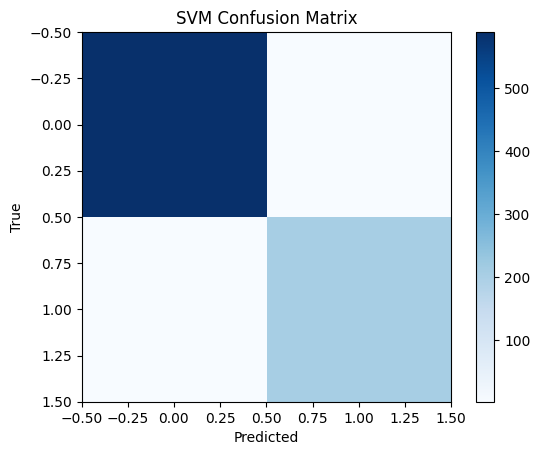

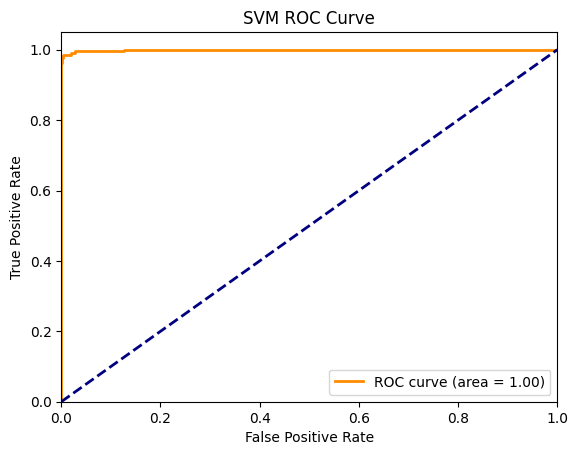

XGBoost Accuracy: 0.99
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.99      0.98      0.98       209

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



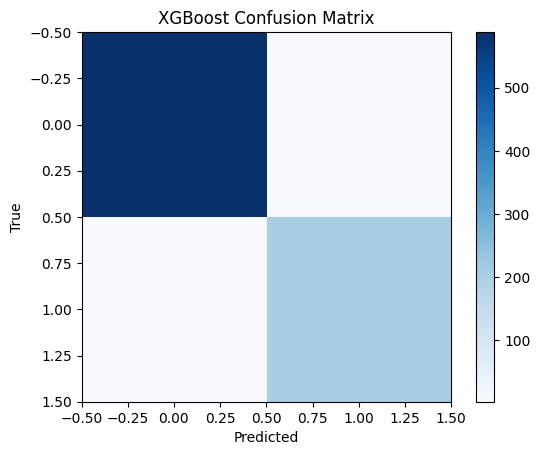

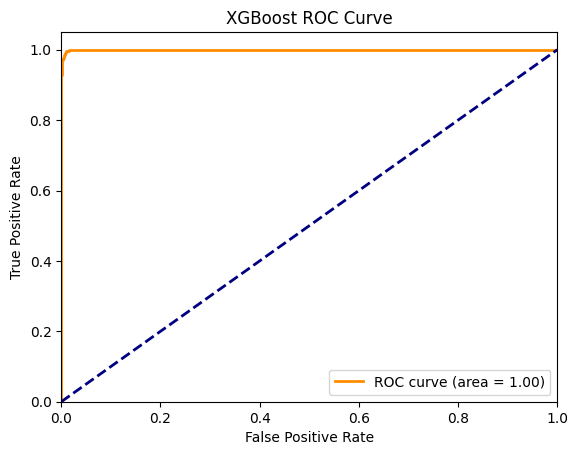

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.98375
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.97      0.97      0.97       209

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



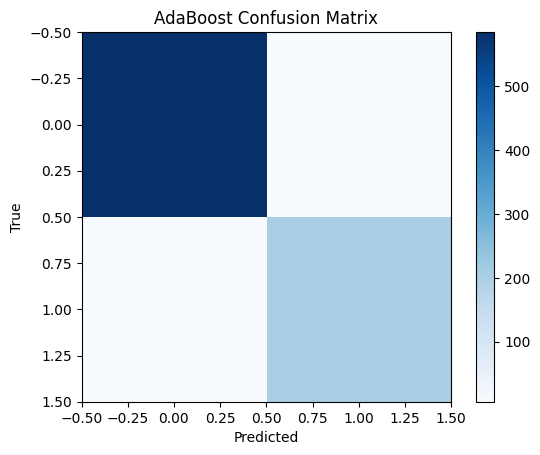

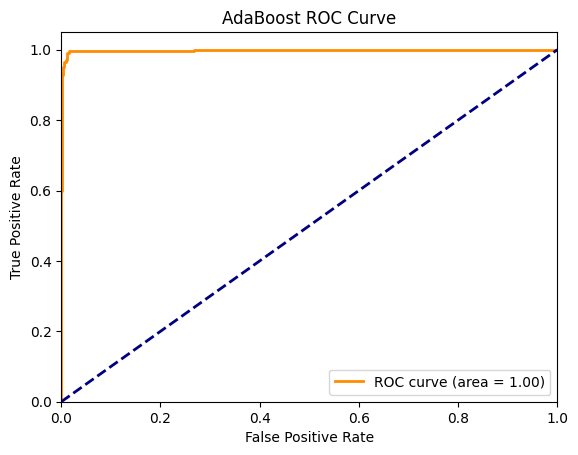

Random Forest Accuracy: 0.98125
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       591
           1       0.98      0.94      0.96       209

    accuracy                           0.98       800
   macro avg       0.98      0.97      0.98       800
weighted avg       0.98      0.98      0.98       800



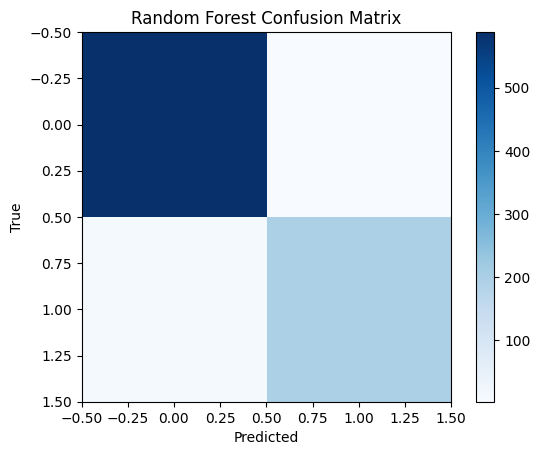

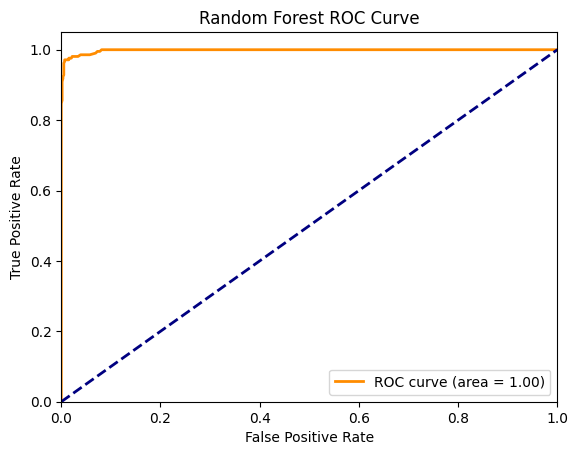

Stochastic Gradient Boosting Accuracy: 0.99125
Stochastic Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       591
           1       0.98      0.99      0.98       209

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



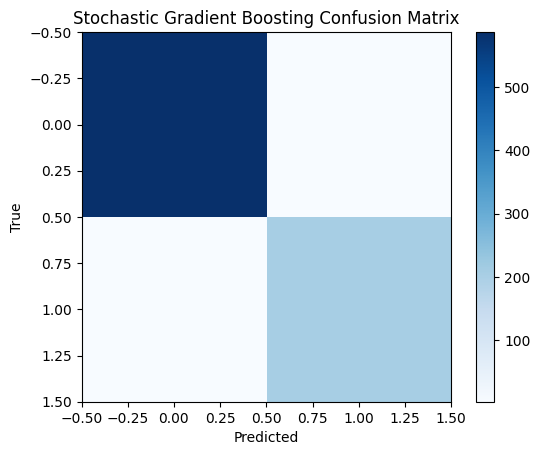

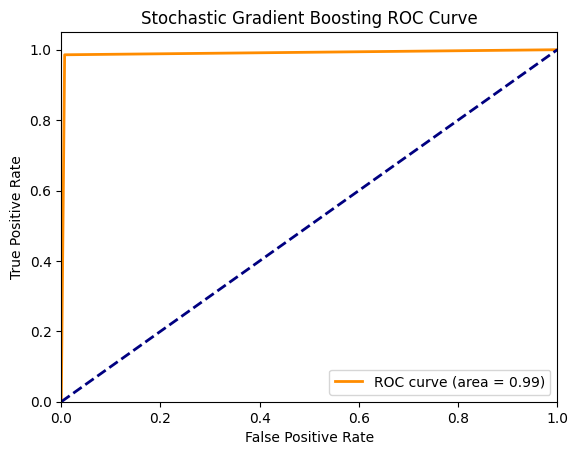

In [40]:
# Loop through classifiers
for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(x_train_combined, y_train_int)
    
    # Evaluate the classifier
    y_pred = clf.predict(x_test_combined)
    accuracy = accuracy_score(y_test_int, y_pred)
    print(f"{clf_name} Accuracy: {accuracy}")
    
    # Classification report
    clf_report = classification_report(np.argmax(y_test, axis=1), y_pred)
    print(f"{clf_name} Classification Report:\n{clf_report}")
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{clf_name} Confusion Matrix")
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC curve
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(x_test_combined)[:,1]
    else:
        y_score = clf.decision_function(x_test_combined)
    
    fpr, tpr, _ = roc_curve(np.argmax(y_test, axis=1), y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{clf_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### **ANN**

In [41]:
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6796 - loss: 1.3631 - val_accuracy: 0.8700 - val_loss: 0.3343
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8003 - loss: 0.6053 - val_accuracy: 0.8525 - val_loss: 0.3935
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8765 - loss: 0.3191 - val_accuracy: 0.7812 - val_loss: 1.1652
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8613 - loss: 0.4222 - val_accuracy: 0.8913 - val_loss: 0.2633
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8986 - loss: 0.2631 - val_accuracy: 0.8275 - val_loss: 0.4539
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8577 - loss: 0.4059 - val_accuracy: 0.8888 - val_loss: 0.3071
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8818 - loss: 0.3116 - val_accuracy: 0.9100 - val_loss: 0.2338
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9119 - loss: 0.2231 - val_accuracy: 0.8938 - 

In [42]:
model.evaluate(x_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9313 - loss: 0.2231 


[0.23148393630981445, 0.9375]

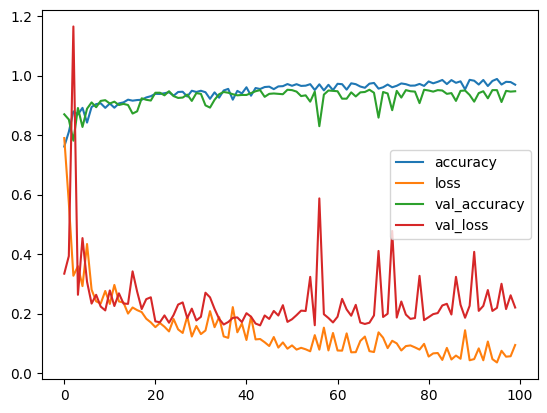

In [43]:
pd.DataFrame(history.history).plot();

In [44]:
model = Sequential()
model.add(Flatten(input_shape=[80, 80, 3]))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
49/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 0.8301

W0000 00:00:1715206346.013638      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6865 - loss: 0.7422 - val_accuracy: 0.8388 - val_loss: 0.4309
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8318 - loss: 0.4136 - val_accuracy: 0.8788 - val_loss: 0.2990
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.3436 - val_accuracy: 0.8350 - val_loss: 0.3981
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8725 - loss: 0.3358 - val_accuracy: 0.8600 - val_loss: 0.3452
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8864 - loss: 0.2941 - val_accuracy: 0.8975 - val_loss: 0.2568
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9008 - loss: 0.2577 - val_accuracy: 0.8487 - val_loss: 0.4162
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8628 - loss: 0.3723 - val_accuracy: 0.9150 - val_loss: 0.3393
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8919 - loss: 0.2821 - val_accuracy: 0.8850 - val_loss: 0.

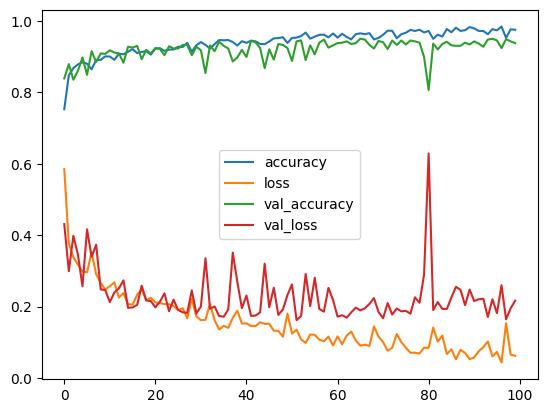

In [45]:
pd.DataFrame(history.history).plot();

In [46]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Not A Ship    0.017828
Ship          0.982172
dtype: float32

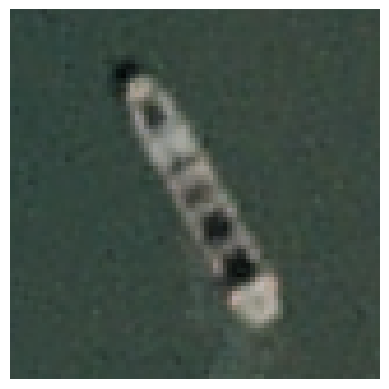

In [47]:
plt.imshow(x_test[0])
plt.axis("off")
plt.show()

In [48]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head(3)

,Not A Ship,Ship
0,0.017828,0.982172
1,0.999932,0.000068
2,0.000307,0.999693


In [49]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head(3)

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0


In [50]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.017828,0.982172,1.0
1,0.999932,0.000068,0.0
2,0.000307,0.999693,1.0
3,0.002845,0.997155,0.0
4,0.983786,0.016214,0.0


In [51]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.017828,0.982172,1.0,-0.017828
1,0.999932,0.000068,0.0,0.000068
2,0.000307,0.999693,1.0,-0.000307
3,0.002845,0.997155,0.0,0.997155
4,0.983786,0.016214,0.0,0.016214
...,...,...,...,...
795,0.019771,0.980229,0.0,0.980229
796,0.007730,0.992270,1.0,-0.007730
797,0.944511,0.055489,0.0,0.055489
798,0.999894,0.000106,0.0,0.000106


In [52]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
528,0.000046,0.999954,0.0,0.999954
14,0.000234,0.999766,0.0,0.999766
628,0.000448,0.999552,0.0,0.999552
783,0.001504,0.998496,0.0,0.998496
441,0.001958,0.998042,0.0,0.998042
484,0.002063,0.997937,0.0,0.997937
201,0.002802,0.997198,0.0,0.997198
3,0.002845,0.997155,0.0,0.997155
757,0.006741,0.993259,0.0,0.993259
603,0.010938,0.989062,0.0,0.989062


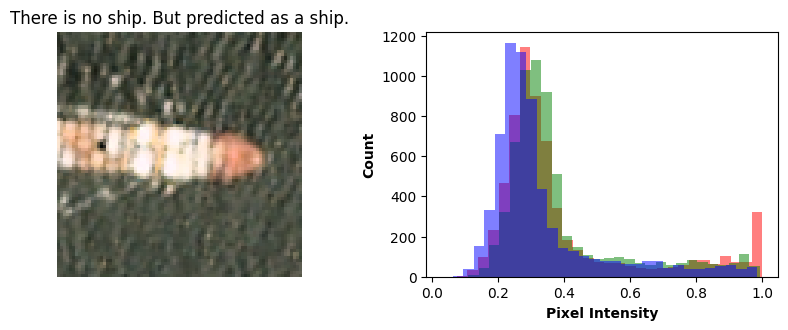

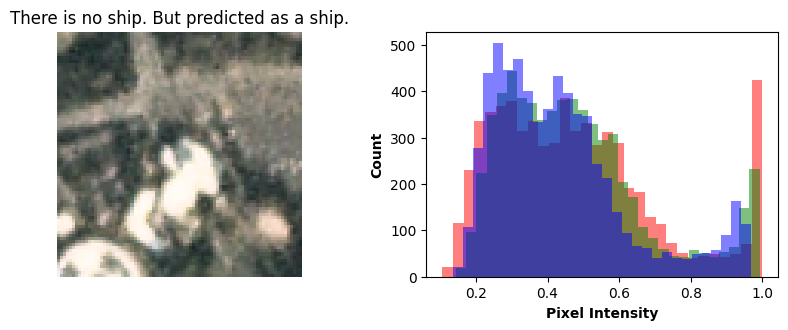

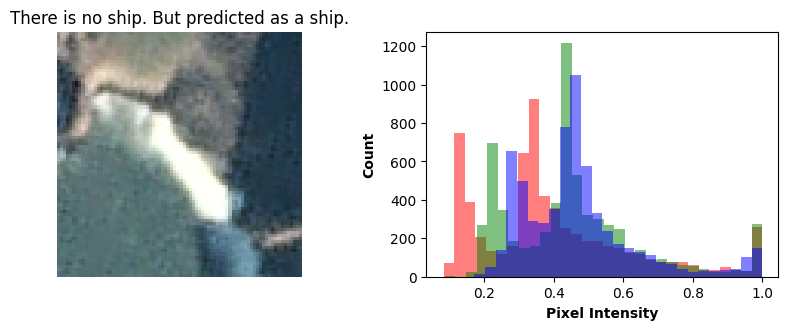

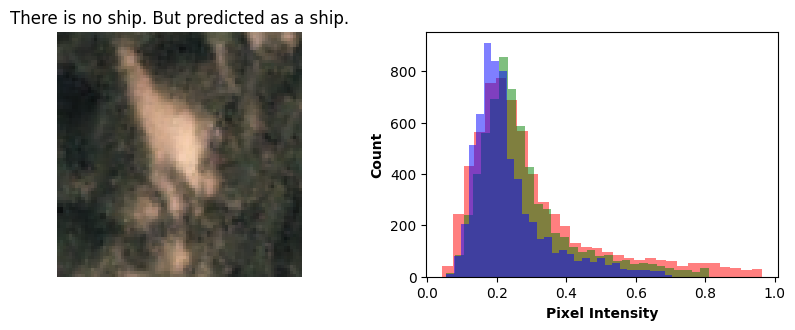

In [53]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()


#Implementation of the function

for i in indexes:
    plotHistogram(i)

In [54]:
predicted_data.sort_values('Difference', ascending=True).head(10)

,Not A Ship,Ship,There is a Ship,Difference
537,0.999923,0.000077,1.0,-0.999923
518,0.998400,0.001600,1.0,-0.998400
578,0.991941,0.008059,1.0,-0.991941
365,0.990809,0.009191,1.0,-0.990809
261,0.981874,0.018126,1.0,-0.981874
322,0.945982,0.054018,1.0,-0.945982
743,0.930156,0.069844,1.0,-0.930156
25,0.772391,0.227609,1.0,-0.772391
36,0.750163,0.249837,1.0,-0.750163
85,0.720704,0.279296,1.0,-0.720704


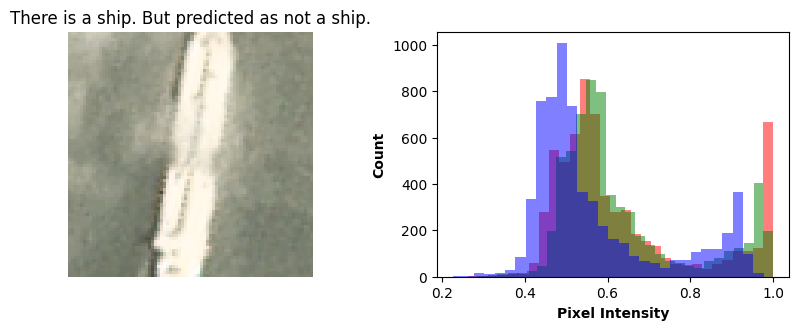

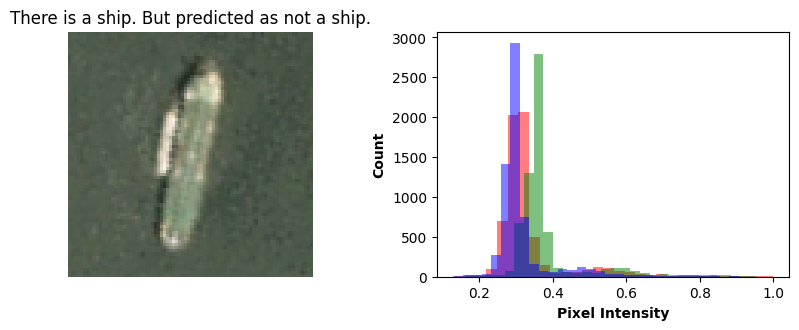

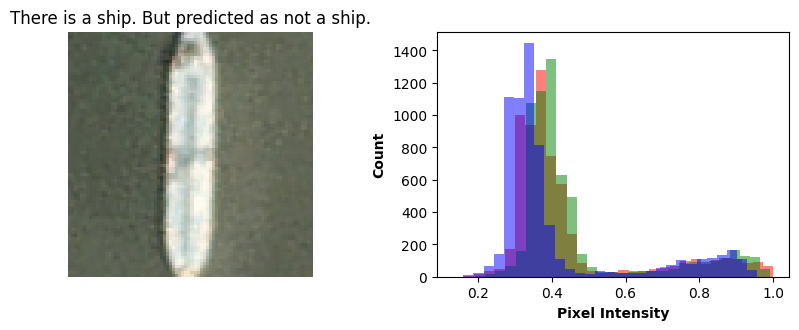

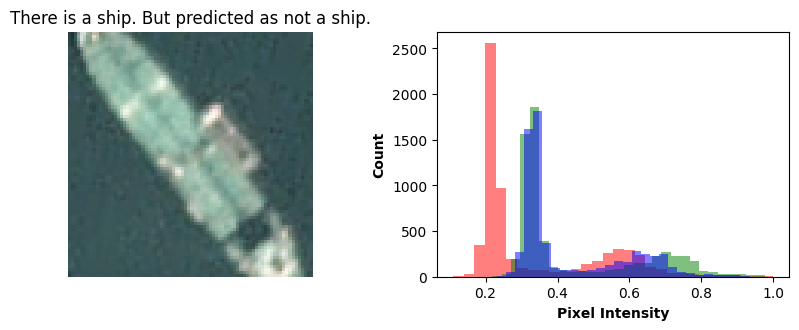

In [55]:
indexes = predicted_data.sort_values('Difference', ascending = True).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is a ship. But predicted as not a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()

    
#Implementation of the function

for i in indexes:
    plotHistogram(i)